In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import random

# Load the CSV file into the DataFrame 
df = pd.read_csv('data/diabetic_data.csv')

In [113]:
from sklearn.preprocessing import LabelEncoder

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr', 'payer_code'])


df['diag_1'] = df['diag_1'].replace('V', '10', regex=True)
df['diag_2'] = df['diag_2'].replace('V', '10', regex=True)
df['diag_3'] = df['diag_3'].replace('V', '10', regex=True)

df['diag_1'] = pd.to_numeric(df['diag_1'], errors='coerce')
df['diag_2'] = pd.to_numeric(df['diag_2'], errors='coerce')
df['diag_3'] = pd.to_numeric(df['diag_3'], errors='coerce')

# Drop rows where any of diag_1, diag_2, or diag_3 are NaN (i.e., where they contained non-numeric values)
df = df.dropna(subset=['diag_1', 'diag_2', 'diag_3'])


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Columns to encode
columns_to_encode = ['race', 'gender', 'age','weight', 'medical_specialty']  # Add more columns as needed

columns_from_15_onwards = df.columns[19:]
columns_to_encode.extend(columns_from_15_onwards)

# Apply LabelEncoder to each specified column
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

# Drop rows with '?' in specific columns
columns_to_check = ['race', 'diag_1', 'diag_2', 'diag_3']
df = df[~df[columns_to_check].isin(['?']).any(axis=1)]

# Save the formatted DataFrame to a new CSV
df.to_csv('data/diabetic_data_formatted.csv', index=False)

print(df)

        race  gender  age  weight  admission_type_id  \
1          3       0    1       1                  1   
2          1       0    2       1                  1   
3          3       1    3       1                  1   
4          3       1    4       1                  1   
5          3       1    5       1                  2   
...      ...     ...  ...     ...                ...   
101761     1       1    7       1                  1   
101762     1       0    8       1                  1   
101763     3       1    7       1                  1   
101764     3       0    8       1                  2   
101765     3       1    7       1                  1   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
1                              1                    7                 3   
2                              1                    7                 2   
3                              1                    7                 2   
4                          

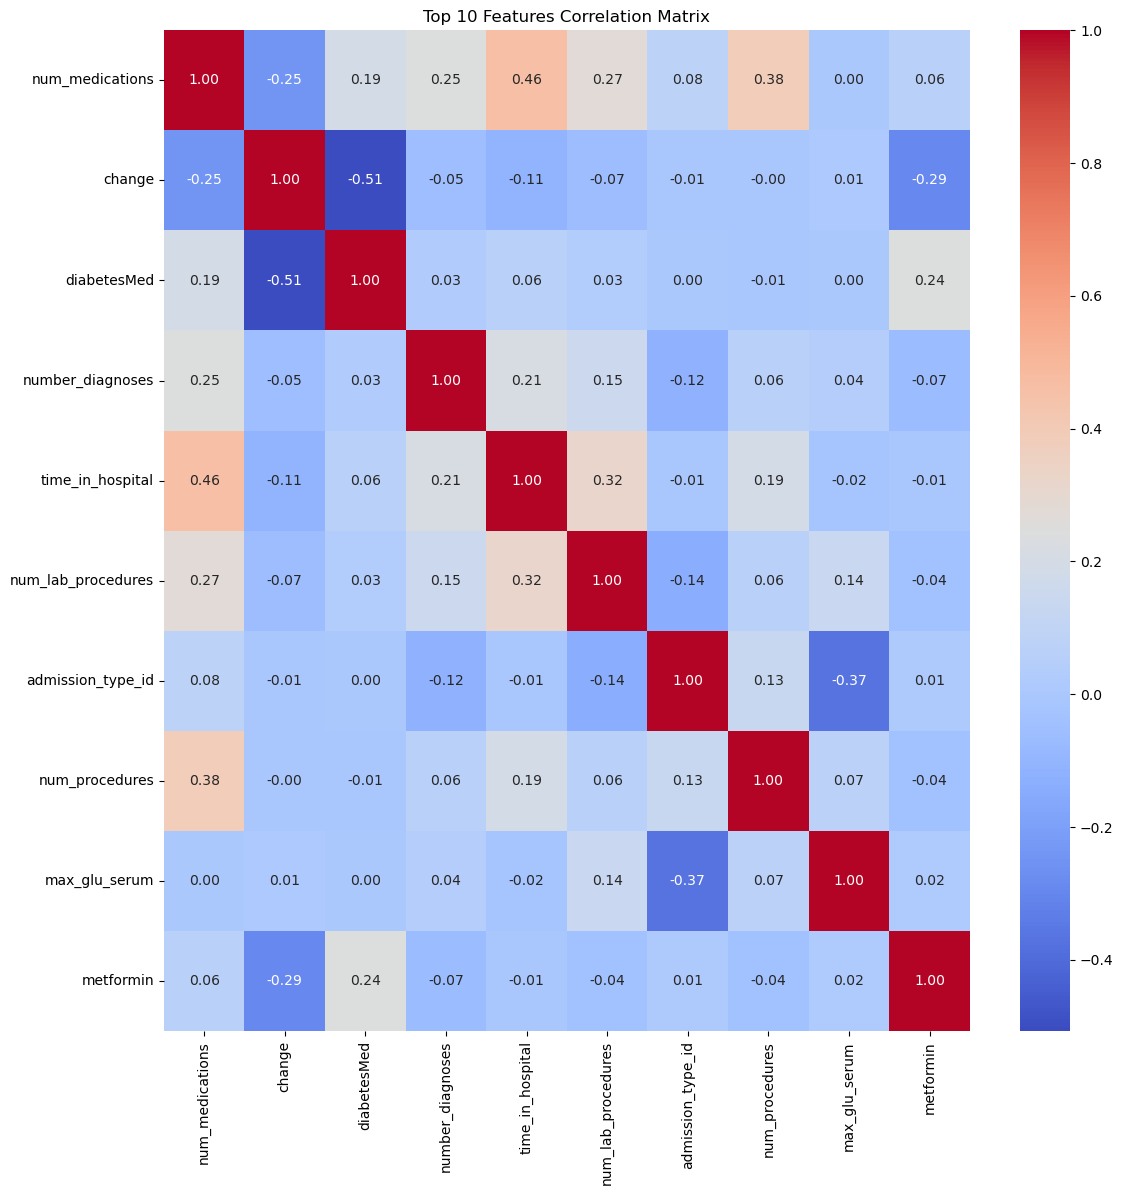

In [114]:
import seaborn as sns

data = pd.read_csv('data/diabetic_data_formatted.csv')

correlation_matrix = data.corr()

# Select top 10 columns based on highest correlations with any variable
top_10_columns = correlation_matrix.abs().sum().nlargest(10).index
top_10_corr_matrix = correlation_matrix.loc[top_10_columns, top_10_columns]

# Heatmap creation
plt.figure(figsize=(13, 13))  # Adjust figure size for better readability
sns.heatmap(top_10_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Top 10 Features Correlation Matrix')
plt.show()

C:\Users\Gogo\AppData\Local\Temp\ipykernel_3388\676512442.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_positive.index, y=top_10_positive.values, palette="Blues_r")


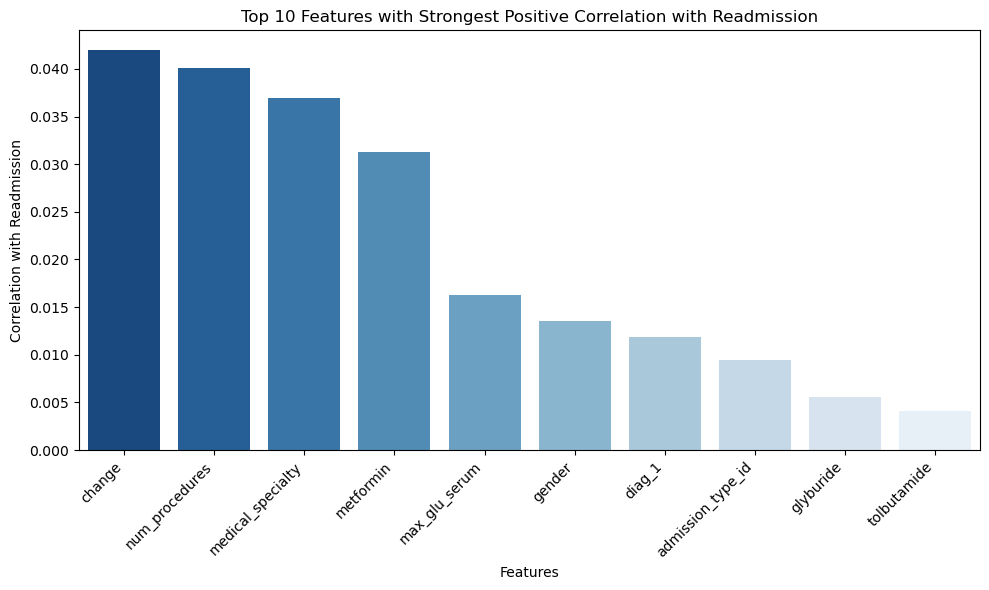

C:\Users\Gogo\AppData\Local\Temp\ipykernel_3388\676512442.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_negative.index, y=top_10_negative.values, palette="Blues_r")


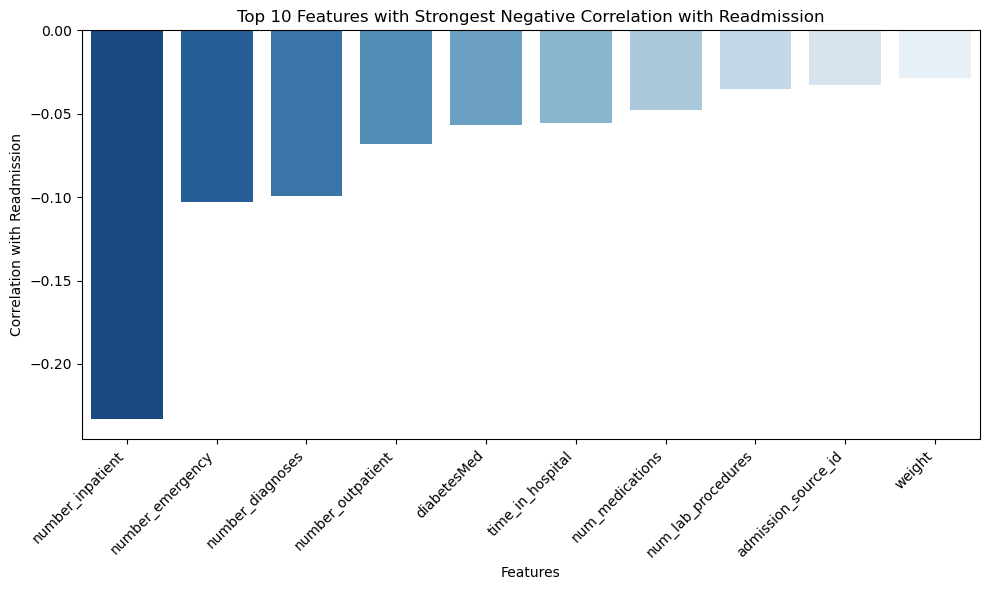

In [115]:
# Compute correlation with 'readmitted' column
correlation_with_readmission = data.corr()["readmitted"].sort_values()

# Select top 10 strongest positive correlations (excluding 'readmitted')
top_10_positive = correlation_with_readmission.drop("readmitted").nlargest(10)

# Select top 10 strongest negative correlations
top_10_negative = correlation_with_readmission.drop("readmitted").nsmallest(10)

# Plot positive correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_positive.index, y=top_10_positive.values, palette="Blues_r")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.title('Top 10 Features with Strongest Positive Correlation with Readmission')
plt.xlabel('Features')
plt.ylabel('Correlation with Readmission')
plt.tight_layout()
plt.show()

# Plot negative correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_negative.index, y=top_10_negative.values, palette="Blues_r")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.title('Top 10 Features with Strongest Negative Correlation with Readmission')
plt.xlabel('Features')
plt.ylabel('Correlation with Readmission')
plt.tight_layout()
plt.show()

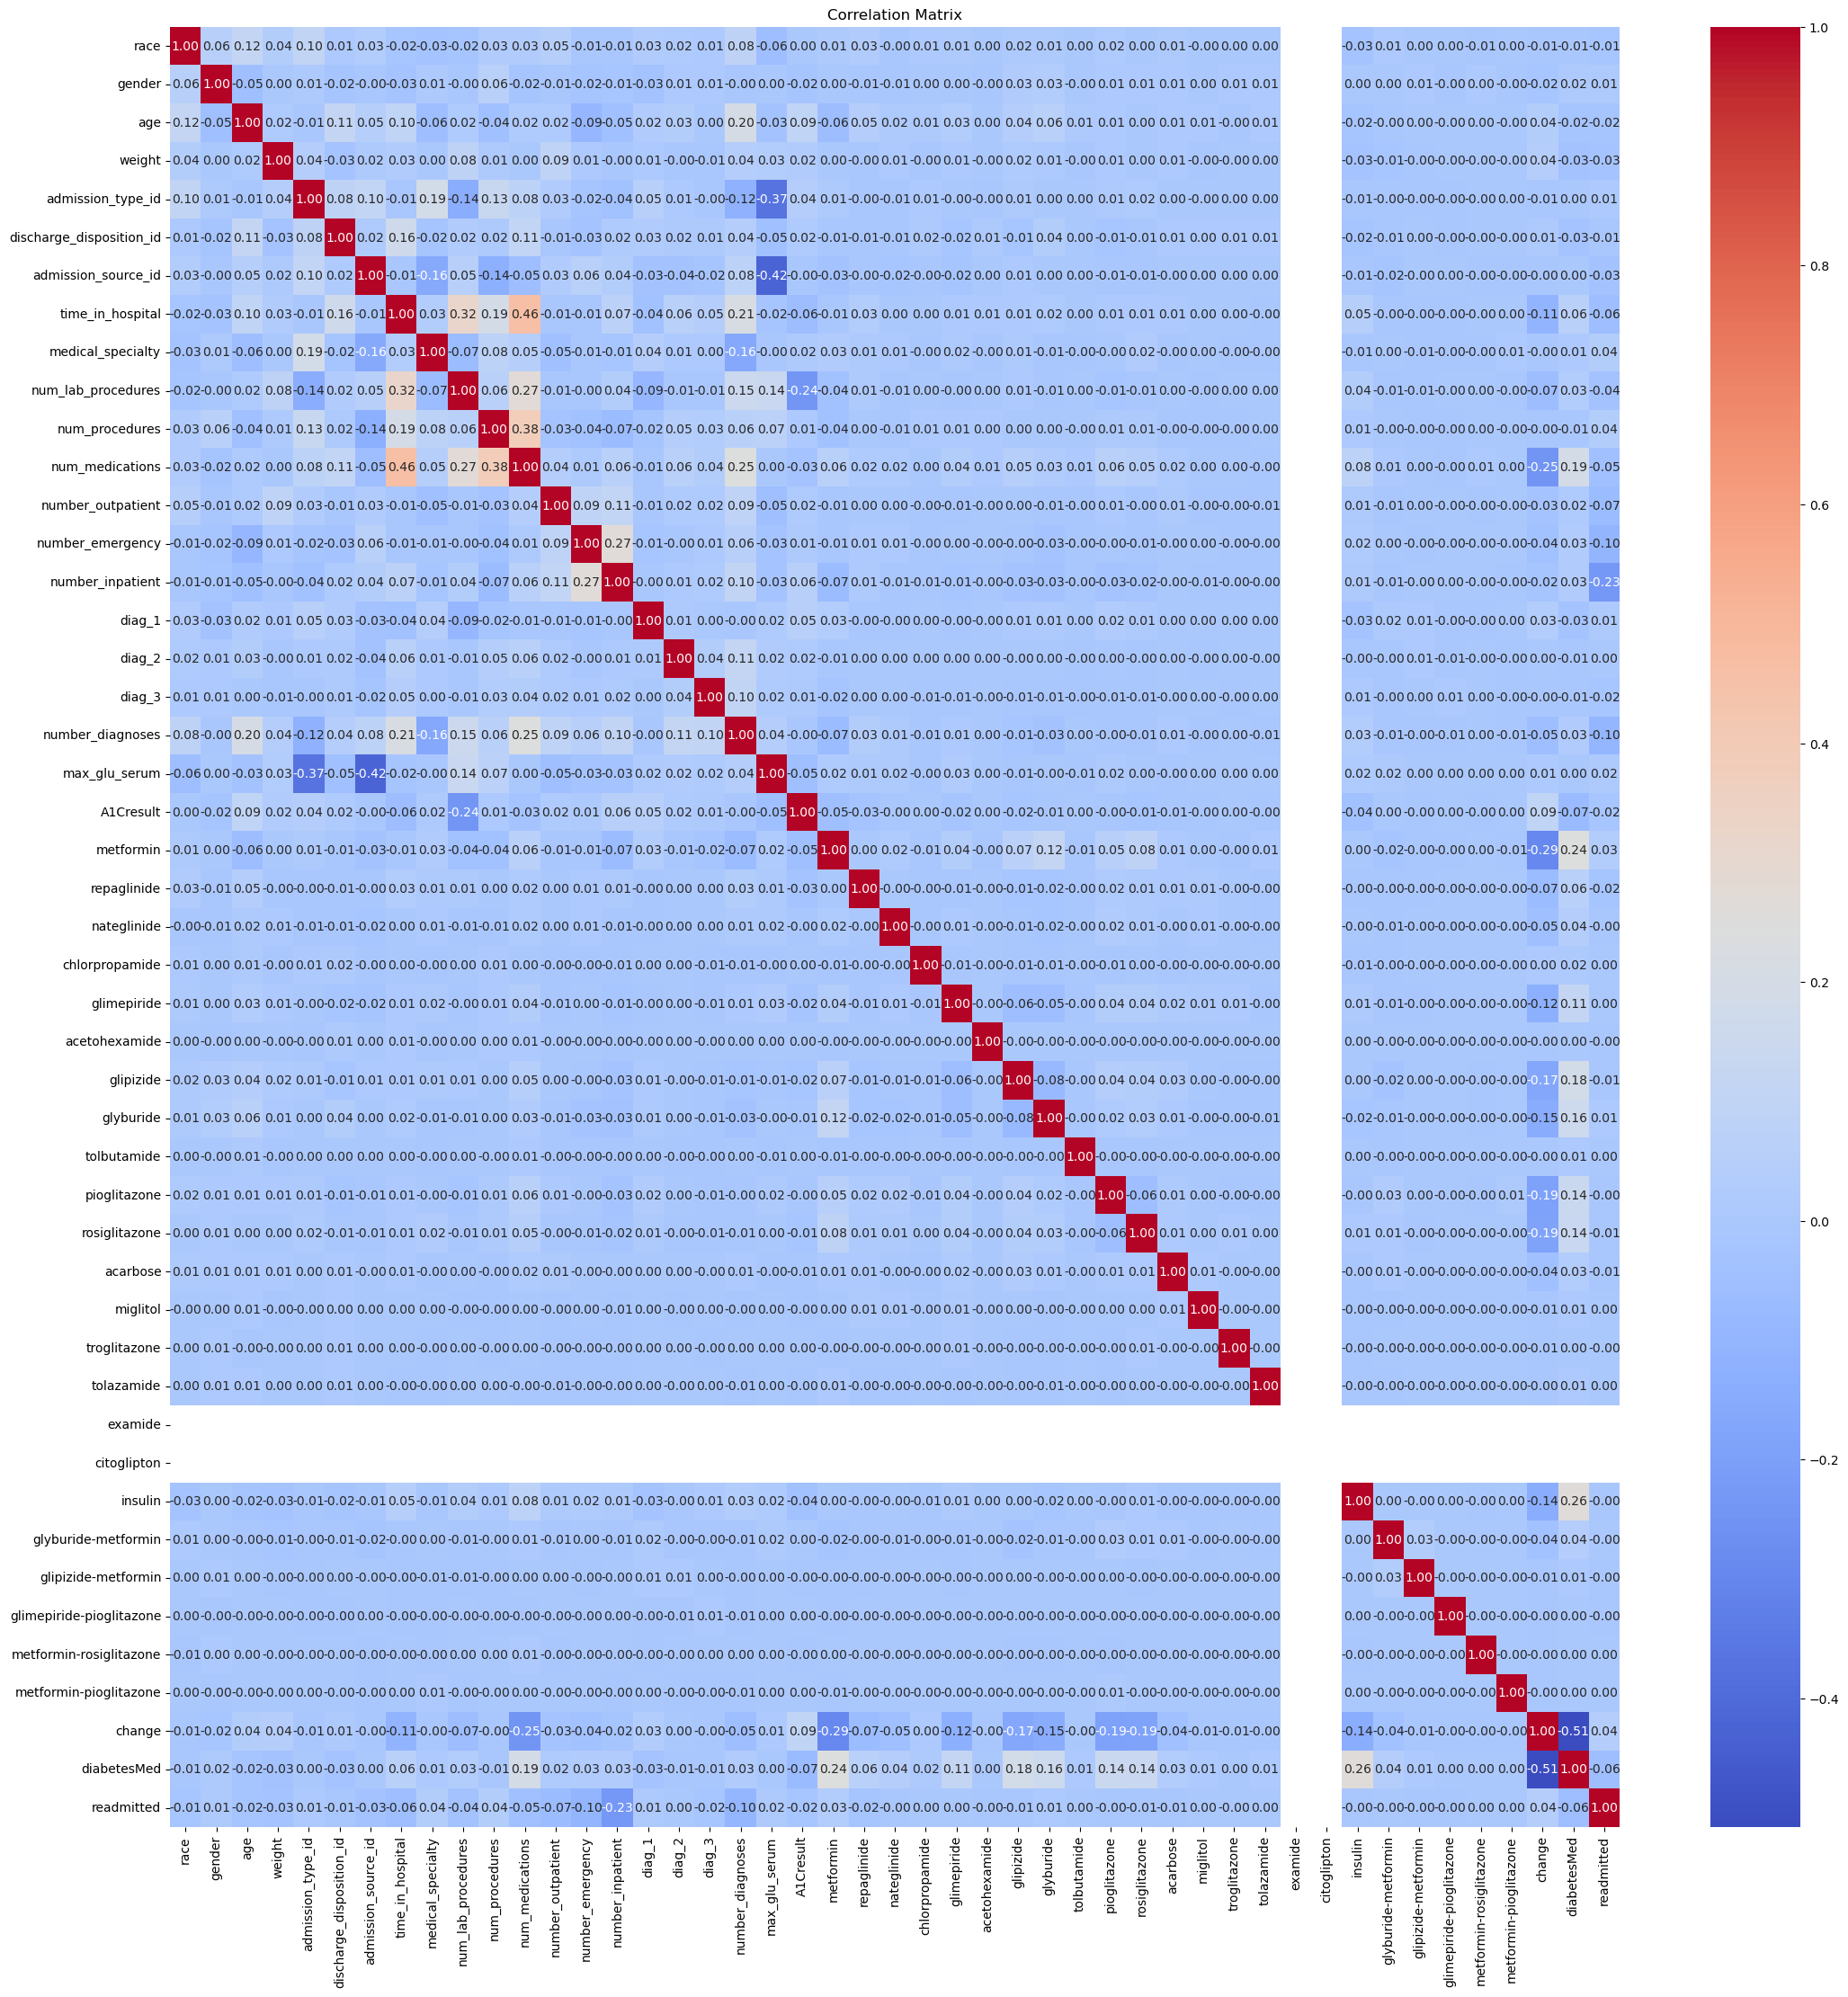

In [116]:
correlation_matrix = data.corr()

# Heatmap creation
plt.figure(figsize=(26, 26))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [117]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA  
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import random

# Filter data for selected features
# These were the top 3 features that appeared to hold most of the data set variance from correlation matrix
selected_features = ['num_medications', 'time_in_hospital', 'num_procedures', 'readmitted']
data = data[selected_features]

# Separate features and target
X = data.drop(columns=['readmitted'])
y = data['readmitted']

# Use a fraction of the data for faster processing
X = X.sample(frac=0.02, random_state=42) 
y = y[X.index] 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random.randint(0, 100))

# Data Standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define GridSearchCV parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 0.1, 0.01],  
    'kernel': ['rbf'],  
    'class_weight': [None, 'balanced']  
}

# Implement GridSearchCV for SVC
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=4, scoring='accuracy', n_jobs=-1)

print("Starting model training with Grid Search...")
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X_test)

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Starting model training with Grid Search...
Best Parameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.6142131979695431
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.44      0.06      0.11        62
           2       0.62      0.96      0.75       122

    accuracy                           0.61       197
   macro avg       0.36      0.34      0.29       197
weighted avg       0.53      0.61      0.50       197



D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
